In [1]:
pip install pyodbc pandas matplotlib seaborn


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
#Kết nối đến SQL Sever 
import pyodbc
import pandas as pd

# ⚙️ Kết nối SQL Server
conn = pyodbc.connect(
    'DRIVER={ODBC Driver 17 for SQL Server};'
    'SERVER=LAPTOP-9T6REJE6;'       # hoặc tên máy chủ của bạn
    'DATABASE=Sale;'  # thay bằng tên DB thật
    'Trusted_Connection=yes;' # nếu đăng nhập bằng Windows
)


In [13]:
#Thực hiện truy vấn Doanh thu, số lượng đơn hàng, theo thời gian, sản phẩm, khu vực
query_full = """
SELECT 
    YEAR(h.OrderDate) AS Nam,
    t.Name AS KhuVuc,
    p.Name AS SanPham,
    SUM(d.OrderQty) AS TongSoLuong,
    COUNT(DISTINCT d.SalesOrderID) AS SoDonHang,
    SUM(d.LineTotal) AS DoanhThu
FROM Sales.SalesOrderHeader h
JOIN Sales.SalesOrderDetail d ON h.SalesOrderID = d.SalesOrderID
JOIN Sales.SalesTerritory t   ON h.TerritoryID  = t.TerritoryID
JOIN Production.Product p     ON d.ProductID    = p.ProductID
GROUP BY YEAR(h.OrderDate), t.Name, p.Name
ORDER BY Nam, KhuVuc, DoanhThu DESC;
"""


pd.set_option('display.max_rows', None)
print(df_full)


       Nam          KhuVuc                           SanPham  TongSoLuong  \
0     2011       Australia                  Road-150 Red, 62           69   
1     2011       Australia                  Road-150 Red, 48           68   
2     2011       Australia                  Road-150 Red, 56           67   
3     2011       Australia                  Road-150 Red, 52           59   
4     2011       Australia                  Road-150 Red, 44           55   
5     2011       Australia            Mountain-100 Black, 48           19   
6     2011       Australia            Mountain-100 Black, 44           16   
7     2011       Australia           Mountain-100 Silver, 44           15   
8     2011       Australia           Mountain-100 Silver, 38           14   
9     2011       Australia            Mountain-100 Black, 38           13   
10    2011       Australia           Mountain-100 Silver, 42           12   
11    2011       Australia            Mountain-100 Black, 42           12   

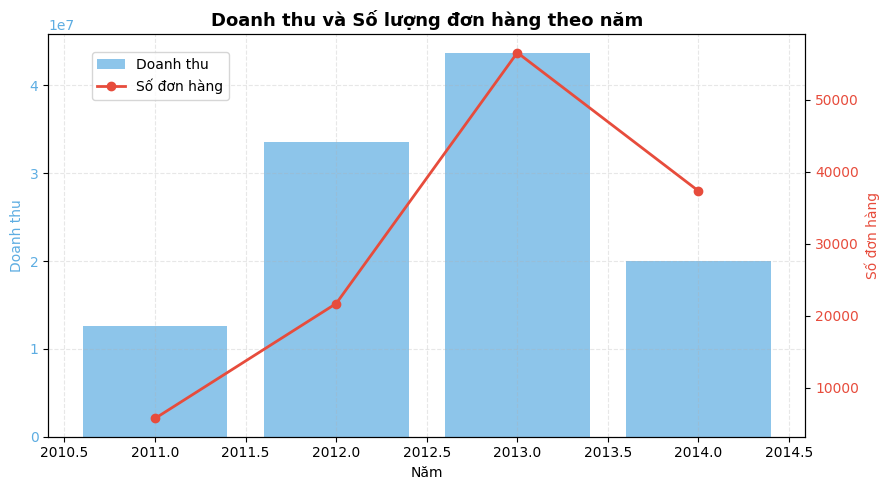

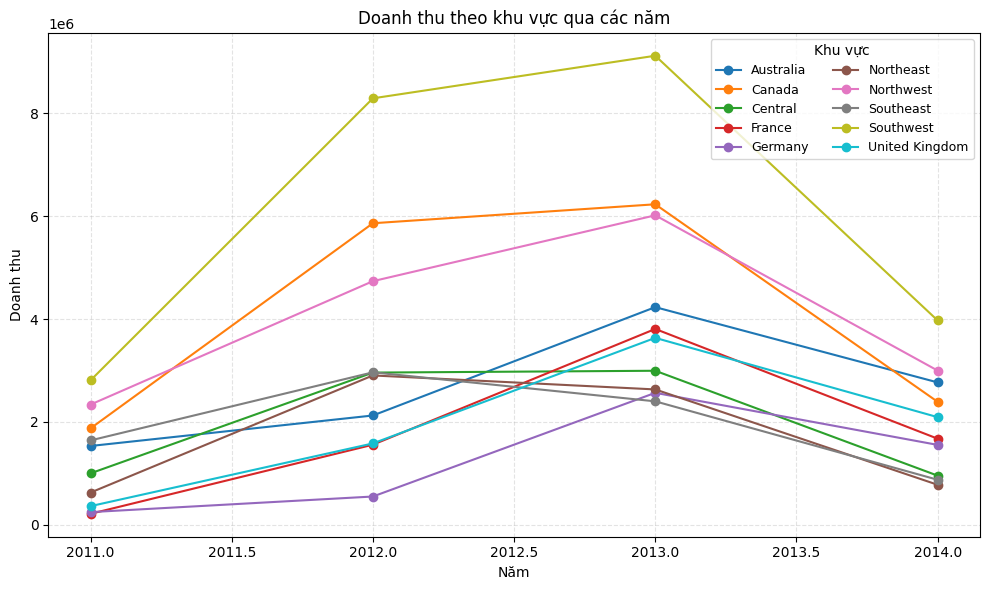

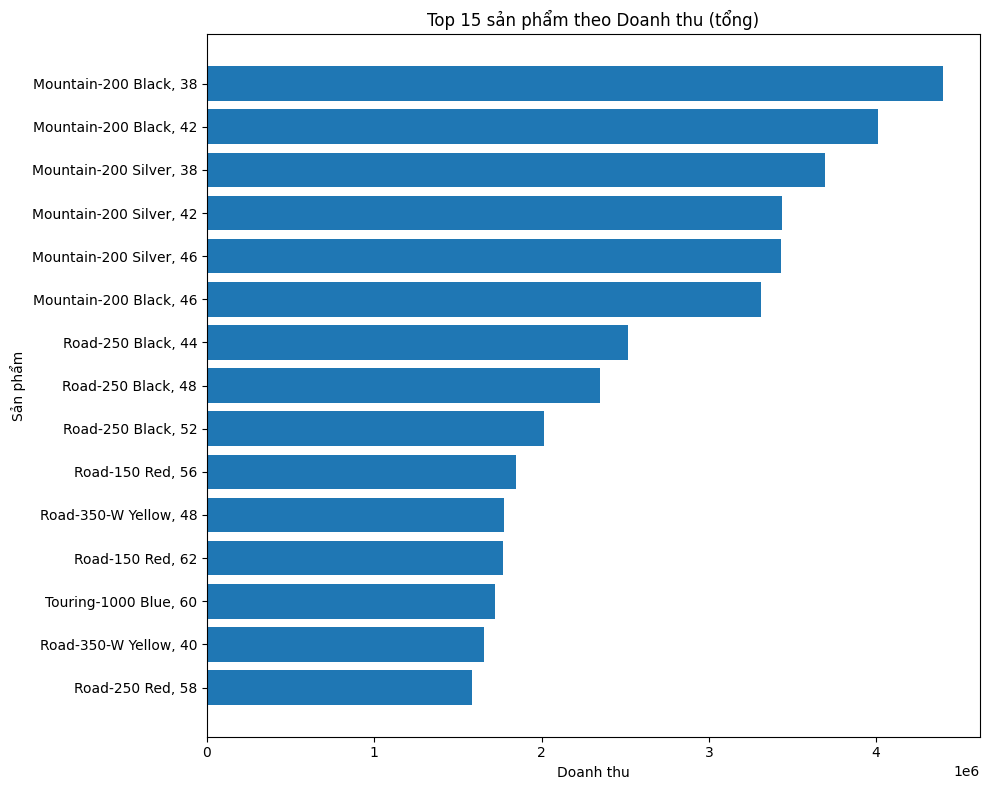

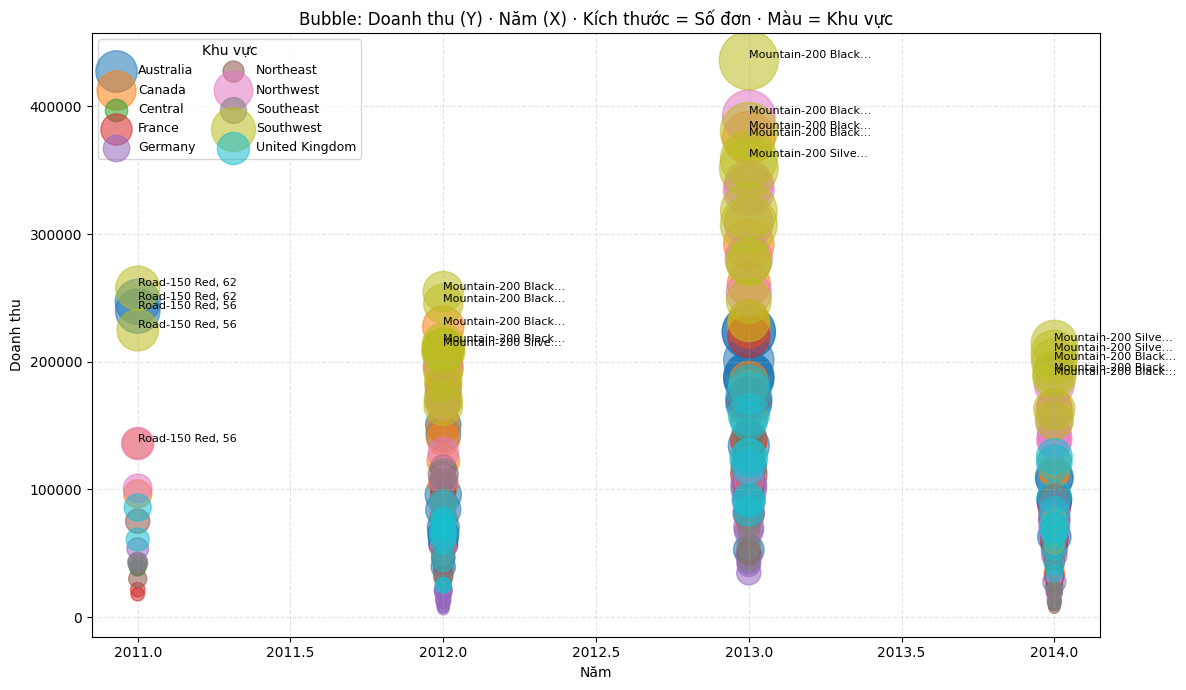

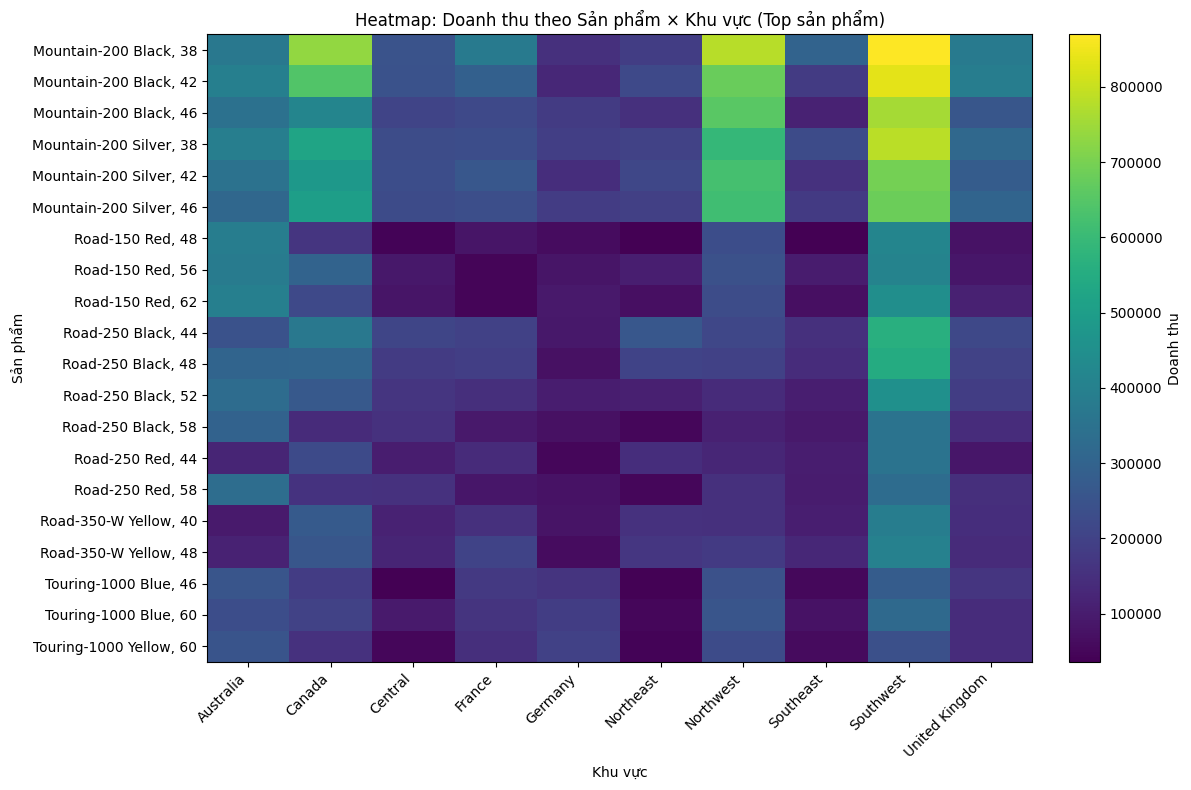

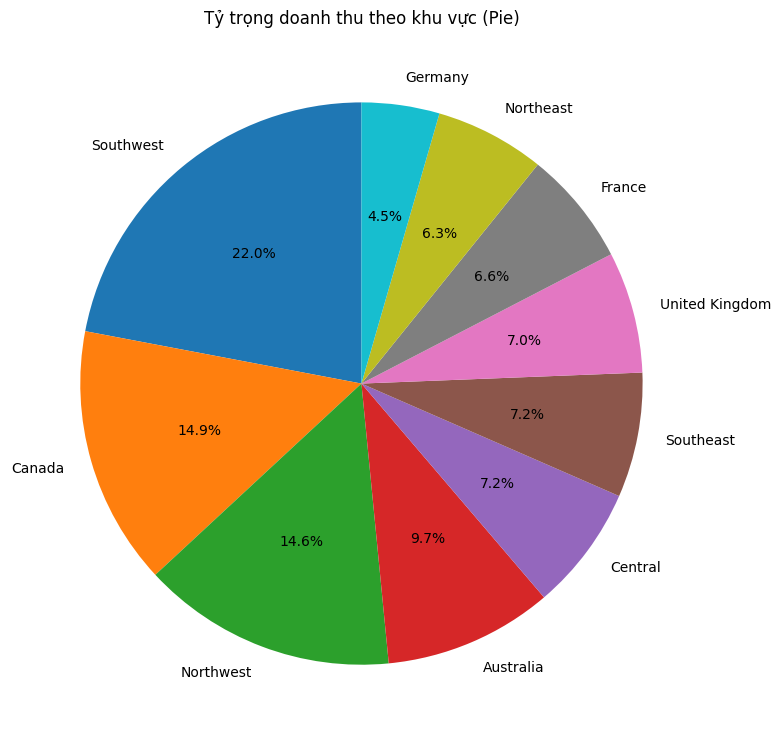

In [16]:
#Vẽ EDA phân tích Doanh thu, số lượng đơn hàng, theo thời gian, sản phẩm, khu vực
# === YÊU CẦU: df_full đã sẵn có với các cột:
# Nam (int), KhuVuc (str), SanPham (str), TongSoLuong (numeric),
# SoDonHang (numeric), DoanhThu (numeric)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Bảo đảm kiểu dữ liệu đúng
df = df_full.copy()
df["Nam"] = df["Nam"].astype(int)
for c in ["TongSoLuong", "SoDonHang", "DoanhThu"]:
    df[c] = pd.to_numeric(df[c])

# Tổng hợp dữ liệu theo năm
by_year = df.groupby("Nam", as_index=False).agg(
    DoanhThu=("DoanhThu", "sum"),
    SoDonHang=("SoDonHang", "sum")
)

# Tạo biểu đồ kết hợp: cột (Doanh thu) + đường (Số đơn hàng)
fig, ax1 = plt.subplots(figsize=(9,5))

# ---- Trục 1: Doanh thu (cột)
ax1.bar(by_year["Nam"], by_year["DoanhThu"], color="#5DADE2", alpha=0.7, label="Doanh thu")
ax1.set_xlabel("Năm")
ax1.set_ylabel("Doanh thu", color="#5DADE2")
ax1.tick_params(axis='y', labelcolor="#5DADE2")
ax1.grid(True, linestyle="--", alpha=0.3)

# ---- Trục 2: Số đơn hàng (đường)
ax2 = ax1.twinx()
ax2.plot(by_year["Nam"], by_year["SoDonHang"], color="#E74C3C", marker="o", linewidth=2, label="Số đơn hàng")
ax2.set_ylabel("Số đơn hàng", color="#E74C3C")
ax2.tick_params(axis='y', labelcolor="#E74C3C")

# ---- Tiêu đề & chú thích
plt.title("Doanh thu và Số lượng đơn hàng theo năm", fontsize=13, weight="bold")
fig.tight_layout()
fig.legend(loc="upper left", bbox_to_anchor=(0.1, 0.9))
plt.show()

# ---------------------------
# 2) Doanh thu theo khu vực qua các năm – Multi-line (dễ đọc)
# ---------------------------
by_year_region = df.groupby(["Nam","KhuVuc"], as_index=False)["DoanhThu"].sum()
plt.figure(figsize=(10,6))
for region, g in by_year_region.groupby("KhuVuc"):
    g = g.sort_values("Nam")
    plt.plot(g["Nam"], g["DoanhThu"], marker="o", label=region)

plt.title("Doanh thu theo khu vực qua các năm")
plt.xlabel("Năm")
plt.ylabel("Doanh thu")
plt.grid(True, linestyle="--", alpha=0.35)
plt.legend(title="Khu vực", ncol=2, fontsize=9)
plt.tight_layout()
plt.show()

# (Nếu muốn Stacked bar thay cho Multi-line, dùng đoạn dưới – tùy chọn)
# pivot_reg = by_year_region.pivot(index="Nam", columns="KhuVuc", values="DoanhThu").fillna(0)
# plt.figure(figsize=(10,6))
# bottom = np.zeros(len(pivot_reg.index))
# for col in pivot_reg.columns:
#     plt.bar(pivot_reg.index, pivot_reg[col], bottom=bottom, label=col)
#     bottom += pivot_reg[col].values
# plt.title("Doanh thu theo khu vực (Stacked Bar)")
# plt.xlabel("Năm"); plt.ylabel("Doanh thu"); plt.legend(title="Khu vực", ncol=2, fontsize=9)
# plt.tight_layout(); plt.show()

# ---------------------------
# 3) Horizontal bar – Top N sản phẩm theo Doanh thu
# ---------------------------
TOP_N = 15
top_prod = (df.groupby("SanPham", as_index=False)["DoanhThu"].sum()
              .sort_values("DoanhThu", ascending=False).head(TOP_N))
tp = top_prod.sort_values("DoanhThu", ascending=True)  # để vẽ ngang đẹp

plt.figure(figsize=(10,8))
plt.barh(tp["SanPham"], tp["DoanhThu"])
plt.title(f"Top {TOP_N} sản phẩm theo Doanh thu (tổng)")
plt.xlabel("Doanh thu")
plt.ylabel("Sản phẩm")
plt.tight_layout()
plt.show()

# ---------------------------
# 4) Quan hệ nhiều chiều – chọn 1 trong 2:
#    4a) Bubble chart: X=Nam, Y=DoanhThu, Size=SoDonHang, Color=KhuVuc
# ---------------------------
# Lọc Top sản phẩm để đỡ rối
topN_for_bubble = (df.groupby("SanPham")["DoanhThu"].sum()
                     .sort_values(ascending=False).head(12).index)
bub = df[df["SanPham"].isin(topN_for_bubble)].copy()

# Scale kích thước theo SoDonHang
min_size, max_size = 50, 1800
s_scaled = (bub["SoDonHang"] - bub["SoDonHang"].min()) / max(1, (bub["SoDonHang"].max() - bub["SoDonHang"].min()))
bub["Size"] = min_size + s_scaled * (max_size - min_size)

plt.figure(figsize=(12,7))
for region, g in bub.groupby("KhuVuc"):
    plt.scatter(g["Nam"], g["DoanhThu"], s=g["Size"], alpha=0.55, label=region)

# Gắn nhãn vài điểm nổi bật (Top theo DoanhThu mỗi năm)
lab = (bub.sort_values(["Nam","DoanhThu"], ascending=[True,False])
          .groupby("Nam").head(5))
for _, row in lab.iterrows():
    label = (row["SanPham"][:18] + "…") if len(row["SanPham"]) > 20 else row["SanPham"]
    plt.text(row["Nam"], row["DoanhThu"], label, fontsize=8, ha="left", va="bottom")

plt.title("Bubble: Doanh thu (Y) · Năm (X) · Kích thước = Số đơn · Màu = Khu vực")
plt.xlabel("Năm")
plt.ylabel("Doanh thu")
plt.grid(True, linestyle="--", alpha=0.35)
plt.legend(title="Khu vực", ncol=2, fontsize=9)
plt.tight_layout()
plt.show()

# ---------------------------
#    4b) Heatmap Product × Region – Doanh thu (nếu muốn heatmap thay bubble)
# ---------------------------
topN_for_heat = (df.groupby("SanPham")["DoanhThu"].sum()
                   .sort_values(ascending=False).head(20).index)
heat_df = (df[df["SanPham"].isin(topN_for_heat)]
           .pivot_table(index="SanPham", columns="KhuVuc", values="DoanhThu", aggfunc="sum", fill_value=0))

plt.figure(figsize=(12,8))
im = plt.imshow(heat_df.values, aspect="auto")
plt.title("Heatmap: Doanh thu theo Sản phẩm × Khu vực (Top sản phẩm)")
plt.xlabel("Khu vực")
plt.ylabel("Sản phẩm")
plt.xticks(ticks=np.arange(heat_df.shape[1]), labels=heat_df.columns, rotation=45, ha="right")
plt.yticks(ticks=np.arange(heat_df.shape[0]), labels=heat_df.index)
plt.colorbar(im, fraction=0.046, pad=0.04, label="Doanh thu")
plt.tight_layout()
plt.show()

# ---------------------------
# 5) Pie / Donut – Tỷ trọng doanh thu theo khu vực (toàn bộ)
# ---------------------------
share_region = df.groupby("KhuVuc", as_index=False)["DoanhThu"].sum().sort_values("DoanhThu", ascending=False)

# Pie
plt.figure(figsize=(8,8))
plt.pie(share_region["DoanhThu"], labels=share_region["KhuVuc"], autopct="%1.1f%%", startangle=90)
plt.title("Tỷ trọng doanh thu theo khu vực (Pie)")
plt.tight_layout()
plt.show()




In [27]:
query_full = """
SELECT
    YEAR(h.OrderDate) AS Nam,
    DATEPART(QUARTER, h.OrderDate) AS [Quy],
    MONTH(h.OrderDate) AS Thang,
    SUM(d.LineTotal) AS DoanhThu,
    COUNT(DISTINCT d.SalesOrderID) AS SoDonHang
FROM Sales.SalesOrderHeader AS h
JOIN Sales.SalesOrderDetail AS d 
    ON h.SalesOrderID = d.SalesOrderID
GROUP BY 
    YEAR(h.OrderDate),
    DATEPART(QUARTER, h.OrderDate),
    MONTH(h.OrderDate)
ORDER BY 
    Nam,
    [Quy],
    Thang;
"""
 

pd.set_option('display.max_rows', None)
print(df_full)




       Nam          KhuVuc                           SanPham  TongSoLuong  \
0     2011       Australia                  Road-150 Red, 62           69   
1     2011       Australia                  Road-150 Red, 48           68   
2     2011       Australia                  Road-150 Red, 56           67   
3     2011       Australia                  Road-150 Red, 52           59   
4     2011       Australia                  Road-150 Red, 44           55   
5     2011       Australia            Mountain-100 Black, 48           19   
6     2011       Australia            Mountain-100 Black, 44           16   
7     2011       Australia           Mountain-100 Silver, 44           15   
8     2011       Australia           Mountain-100 Silver, 38           14   
9     2011       Australia            Mountain-100 Black, 38           13   
10    2011       Australia           Mountain-100 Silver, 42           12   
11    2011       Australia            Mountain-100 Black, 42           12   

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ===== 0) Chuẩn hóa dữ liệu =====
df = df_full.copy()
for c in ["Nam","Quy","Thang","TongSoLuong","SoDonHang","DoanhThu"]:
    df[c] = pd.to_numeric(df[c])

# Cột thời gian YYYY-MM để vẽ theo tháng
df["YearMonth"] = pd.to_datetime(df["Nam"].astype(str) + "-" + df["Thang"].astype(str) + "-01")

# Tổng hợp theo THÁNG
mth = df.groupby("YearMonth", as_index=False).agg(
    DoanhThu=("DoanhThu","sum"),
    SoDonHang=("SoDonHang","sum")
)
mth["AOV"] = mth["DoanhThu"] / mth["SoDonHang"]  # Giá trị TB/đơn

# Tổng hợp theo QUÝ × NĂM
qtr = df.groupby(["Nam","Quy"], as_index=False).agg(
    DoanhThu=("DoanhThu","sum"),
    SoDonHang=("SoDonHang","sum")
)

# Pivot cho HEATMAP Năm × Tháng
heat = (df.groupby(["Nam","Thang"], as_index=False)["DoanhThu"].sum()
          .pivot(index="Nam", columns="Thang", values="DoanhThu")
          .reindex(columns=range(1,13)).fillna(0))

# ===== 1) Dual-axis: Doanh thu & Số đơn theo THỜI GIAN (tháng) =====
fig, ax1 = plt.subplots(figsize=(10,5))
ax1.plot(mth["YearMonth"], mth["DoanhThu"], marker="o", label="Doanh thu")
ax1.set_xlabel("Thời gian (tháng)")
ax1.set_ylabel("Doanh thu")
ax1.grid(True, linestyle="--", alpha=0.35)

ax2 = ax1.twinx()
ax2.plot(mth["YearMonth"], mth["SoDonHang"], marker="s", label="Số đơn hàng")
ax2.set_ylabel("Số đơn hàng")

fig.suptitle("Xu hướng theo tháng: Doanh thu & Số đơn", fontsize=12)
fig.tight_layout()
plt.show()

# ===== 2) Heatmap: Doanh thu theo NĂM × THÁNG (mùa vụ nổi bật) =====
plt.figure(figsize=(11,6))
im = plt.imshow(heat.values, aspect="auto")
plt.title("Heatmap Doanh thu – Năm × Tháng")
plt.xlabel("Tháng")
plt.ylabel("Năm")
plt.xticks(ticks=np.arange(heat.shape[1]), labels=heat.columns)
plt.yticks(ticks=np.arange(heat.shape[0]), labels=heat.index)
plt.colorbar(im, fraction=0.046, pad=0.04, label="Doanh thu")
plt.tight_layout()
plt.show()

# ===== 3) Line: Doanh thu theo QUÝ cho từng NĂM (chu kỳ Q1–Q4) =====
plt.figure(figsize=(10,5))
for y, g in qtr.groupby("Nam"):
    g = g.sort_values("Quy")
    plt.plot(g["Quy"], g["DoanhThu"], marker="o", label=str(y))
plt.title("Doanh thu theo quý (so sánh giữa các năm)")
plt.xlabel("Quý")
plt.ylabel("Doanh thu")
plt.xticks([1,2,3,4], ["Q1","Q2","Q3","Q4"])
plt.grid(True, linestyle="--", alpha=0.35)
plt.legend(title="Năm", ncol=3, fontsize=9)
plt.tight_layout()
plt.show()

# ===== 4) Bar: AOV theo THÁNG (giá trị đơn trung bình) =====
plt.figure(figsize=(10,5))
plt.bar(mth["YearMonth"], mth["AOV"])
plt.title("AOV (Doanh thu/Đơn) theo tháng")
plt.xlabel("Thời gian (tháng)")
plt.ylabel("AOV")
plt.tight_layout()
plt.show()

# ===== 5) YoY %: Tăng trưởng theo THÁNG so với cùng kỳ năm trước =====
# Tạo cặp (Năm,Tháng) để xoay
df_yoy = (df.groupby(["Nam","Thang"], as_index=False)["DoanhThu"].sum()
            .sort_values(["Thang","Nam"]))
# Chuyển thành cột theo năm để tính YoY
wide = df_yoy.pivot(index="Thang", columns="Nam", values="DoanhThu").sort_index()
# Tính % YoY theo cột (năm hiện tại / năm trước - 1)
y_cols = wide.columns.tolist()
yoy_lines = []
plt.figure(figsize=(10,5))
for i in range(1, len(y_cols)):
    # %YoY cho năm i so với năm i-1
    yoy = (wide[y_cols[i]] / wide[y_cols[i-1]] - 1) * 100
    plt.plot(wide.index, yoy, marker="o", label=f"YoY {y_cols[i]} vs {y_cols[i-1]}")
plt.title("Tăng trưởng YoY theo tháng (so với cùng kỳ)")
plt.xlabel("Tháng")
plt.ylabel("Tăng trưởng YoY (%)")
plt.xticks(range(1,13))
plt.grid(True, linestyle="--", alpha=0.35)
plt.legend(fontsize=9)
plt.tight_layout()
plt.show()


KeyError: 'Quy'